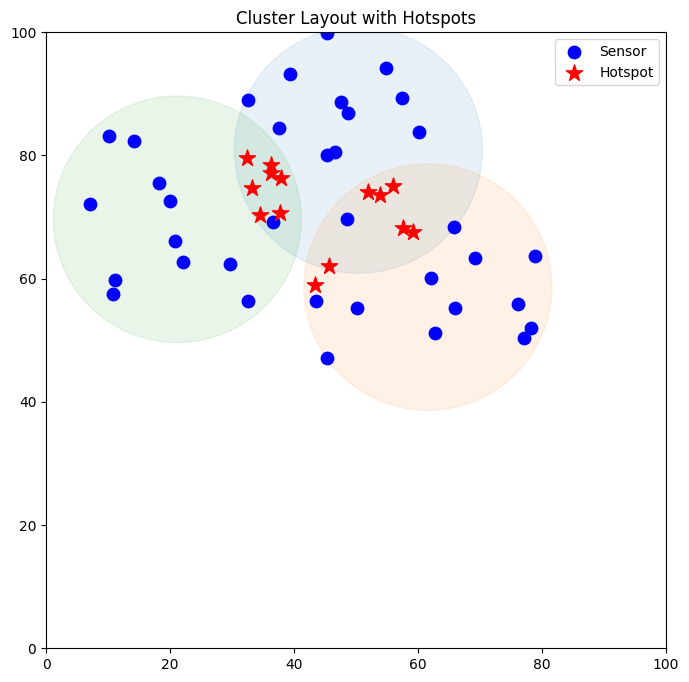

Starting simulation...
EMERGENCY at t=0: Sensor 9 energy critically low (14.4)
EMERGENCY at t=0: Sensor 24 energy critically low (14.5)
EMERGENCY at t=0: Sensor 37 energy critically low (13.1)
EMERGENCY at t=1: Sensor 2 energy critically low (9.1)
EMERGENCY at t=2: Sensor 10 energy critically low (12.0)
EMERGENCY at t=2: Sensor 18 energy critically low (12.6)
EMERGENCY at t=2: Sensor 27 energy critically low (9.8)
EMERGENCY at t=3: Sensor 47 energy critically low (7.8)
EMERGENCY at t=4: Sensor 0 energy critically low (14.6)
EMERGENCY at t=4: Sensor 31 energy critically low (14.9)
EMERGENCY at t=6: Sensor 9 energy critically low (0.0)
EMERGENCY at t=6: Sensor 21 energy critically low (14.8)
EMERGENCY at t=6: Sensor 24 energy critically low (0.0)
EMERGENCY at t=6: Sensor 37 energy critically low (0.0)
EMERGENCY at t=7: Sensor 2 energy critically low (0.0)
EMERGENCY at t=8: Sensor 1 energy critically low (14.1)
EMERGENCY at t=8: Sensor 10 energy critically low (0.0)
EMERGENCY at t=8: Sens

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.spatial.distance import euclidean
import pandas as pd
import matplotlib.animation as animation
import time


# Simulation Parameters
np.random.seed(42)

# Network settings
n_sensors = 50
initial_n_chargers = 3
grid_size = 100

# Simulation timing
simulation_duration = 120  # seconds
time_step = 1             # seconds

# Energy parameters
E_max = 100
T_min = 10
eta = 0.85
charging_rate = 1.5      # units/sec
B_max = 800
B_min = 150

# Clustering
R_c = 20                 # cluster radius
hotspots_per_pair = 2    # hotspots at each pairwise intersection
emergency_threshold = 15 # critical energy


# Helper Functions

def create_initial_clusters(n_clusters, total_sensors, radius, center_std=5):
    num_pairs = n_clusters * (n_clusters - 1) // 2
    total_hotspots = num_pairs * hotspots_per_pair
    base = (total_sensors - total_hotspots) // n_clusters
    extras = (total_sensors - total_hotspots) % n_clusters

    centers = []
    centers.append(np.random.rand(2) * (grid_size - 2*radius) + radius)
    while len(centers) < n_clusters:
        cand = np.random.rand(2) * (grid_size - 2*radius) + radius
        if any(np.linalg.norm(cand - c) < 2*radius for c in centers):
            centers.append(cand)
    centers = np.array(centers) + np.random.normal(0, center_std, (n_clusters, 2))

    points = []
    for i in range(n_clusters):
        count = base + (1 if i < extras else 0)
        angles = np.random.rand(count) * 2*np.pi
        radii = radius * np.sqrt(np.random.rand(count))
        x = centers[i,0] + radii * np.cos(angles)
        y = centers[i,1] + radii * np.sin(angles)
        points.append(np.column_stack((x,y)))
    for i,j in combinations(range(n_clusters),2):
        mid = (centers[i] + centers[j]) / 2
        angles = np.random.rand(hotspots_per_pair) * 2*np.pi
        radii = (radius * 0.3) * np.sqrt(np.random.rand(hotspots_per_pair))
        xh = mid[0] + radii * np.cos(angles)
        yh = mid[1] + radii * np.sin(angles)
        points.append(np.column_stack((xh,yh)))

    sensors = np.vstack(points)
    np.random.shuffle(sensors)
    return sensors, centers

def calculate_priority(E, rho, E_max, E_critical):
    w1, w2, w3 = 0.3, 0.2, 0.5
    D_k = E_max - E_critical
    return w1 * D_k + w2 * (1 - E / E_max) + w3 * rho

def travel_cost(x, y, speed=0.5):
    return euclidean(x, y) * speed

def charging_time_required(sensor_idx, E_k):
    energy_needed = E_max - E_k[sensor_idx]
    return (energy_needed / eta) / charging_rate

def update_energy_levels(E_k, rho_k, dt):
    return np.maximum(E_k - rho_k * dt, 0)

def tsp_with_energy(assigned, P_k, start_pos, battery_level, sensor_positions, E_k):
    if not assigned:
        return [], battery_level
    path = []
    unvisited = set(assigned)
    current = start_pos.copy()
    remaining_battery = battery_level
    while unvisited and remaining_battery > B_min:
        best_sensor, best_score = None, -1
        for s in unvisited:
            dist = euclidean(current, sensor_positions[s])
            score = P_k[s] / (dist + 1e-6)
            if score > best_score:
                best_sensor, best_score = s, score
        if best_sensor is None:
            break
        travel_energy = travel_cost(current, sensor_positions[best_sensor])
        charge_energy = (E_max - E_k[best_sensor]) / eta
        if remaining_battery - travel_energy - charge_energy < B_min:
            break
        remaining_battery -= (travel_energy + charge_energy)
        path.append(best_sensor)
        unvisited.remove(best_sensor)
        current = sensor_positions[best_sensor]
    return path, remaining_battery


# Generate & Visualize Clusters

sensor_positions, cluster_centers = create_initial_clusters(initial_n_chargers, n_sensors, R_c)
dist_to_center = np.min([np.linalg.norm(sensor_positions - c, axis=1) for c in cluster_centers], axis=0)
out = sensor_positions[dist_to_center > R_c]
if len(out) > 0:
    cluster_centers = np.vstack([cluster_centers, out.mean(axis=0)])
n_chargers = len(cluster_centers)

E_k = np.random.uniform(30, 90, n_sensors)
rho_k = np.random.uniform(0.5, 2.5, n_sensors)

inter_pts = [(cluster_centers[i] + cluster_centers[j]) / 2 for i,j in combinations(range(n_chargers),2)]
if inter_pts:
    dists = np.min([np.linalg.norm(sensor_positions - p, axis=1) for p in inter_pts], axis=0)
else:
    dists = np.full(n_sensors, np.inf)
hotspot_mask = dists < (R_c * 0.3)
max_hs = (n_sensors // 2) - 1
if hotspot_mask.sum() > max_hs:
    idxs = np.where(hotspot_mask)[0]
    drop = np.random.choice(idxs, hotspot_mask.sum() - max_hs, replace=False)
    hotspot_mask[drop] = False
rho_k[hotspot_mask] *= 3
E_k[hotspot_mask] = np.random.uniform(15, 40, hotspot_mask.sum())

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, grid_size); ax.set_ylim(0, grid_size)
for idx, c in enumerate(cluster_centers):
    circle = plt.Circle(c, R_c, color=f'C{idx}', alpha=0.1)
    ax.add_patch(circle)
on_hot = sensor_positions[~hotspot_mask]
ax.scatter(on_hot[:,0], on_hot[:,1], c='blue', marker='o', s=80, label='Sensor')
hs = sensor_positions[hotspot_mask]
ax.scatter(hs[:,0], hs[:,1], c='red', marker='*', s=150, label='Hotspot')
ax.set_title("Cluster Layout with Hotspots")
ax.legend(loc='upper right')
plt.show()


# Charger Initialization

charger_positions = cluster_centers.copy()
charger_status = ['idle'] * n_chargers
charger_battery = [B_max] * n_chargers
charger_paths = [[] for _ in range(n_chargers)]
charger_target = [None] * n_chargers
charger_schedules = [[] for _ in range(n_chargers)]


# Simulation Loop

energy_history, status_history, emergency_events = [], [], []
charging_history = {i: [] for i in range(n_sensors)}

print("Starting simulation...")
start_time = time.time()
for t in range(0, simulation_duration + 1, time_step):
    E_k = update_energy_levels(E_k, rho_k, time_step)
    em = np.where(E_k < emergency_threshold)[0]
    for s in em:
        if not any(e[0] == s and abs(e[1] - t) <= 5 for e in emergency_events):
            emergency_events.append((s, t, E_k[s]))
            print(f"EMERGENCY at t={t}: Sensor {s} energy critically low ({E_k[s]:.1f})")

    E_crit = rho_k * T_min
    P_k = calculate_priority(E_k, rho_k, E_max, E_crit)
    dist_mat = np.array([[euclidean(sensor_positions[i], charger_positions[c]) / (P_k[i] + 1e-6)
                          for i in range(n_sensors)] for c in range(n_chargers)])
    primary = np.argmin(dist_mat, axis=0)
    secondary = np.argsort(dist_mat, axis=0)[1]

    for c in range(n_chargers):
        if charger_status[c] not in ['idle', 'emergency']:
            continue

        assigned = list(np.where(primary == c)[0])
        hs_idxs = np.where(hotspot_mask)[0]
        hotspot_secondary = [s for s in hs_idxs if secondary[s] == c and s not in assigned]
        assigned.extend(hotspot_secondary)

        if not assigned:
            continue

        path, _ = tsp_with_energy(assigned, P_k, charger_positions[c], charger_battery[c], sensor_positions, E_k)
        charger_paths[c] = path
        if path:
            charger_status[c] = 'traveling'
            charger_target[c] = path[0]

    for c in range(n_chargers):
        if charger_status[c] == 'traveling':
            tgt = charger_target[c]
            tp = sensor_positions[tgt]
            d = euclidean(charger_positions[c], tp)
            if d <= 1.0:
                charger_status[c] = 'charging'
                ct = charging_time_required(tgt, E_k)
                charger_schedules[c].append((t, tgt, ct))
            else:
                direction = (tp - charger_positions[c]) / d
                prev_pos = charger_positions[c].copy()
                charger_positions[c] += direction * 0.8
                charger_battery[c] -= travel_cost(prev_pos, charger_positions[c])

        elif charger_status[c] == 'charging':
            start, tgt, dur = charger_schedules[c][-1]
            if t >= start + dur:
                E_k[tgt] = E_max
                charger_status[c] = 'idle'
                charger_target[c] = None
                charging_history[tgt].append(t)
            else:
                E_k[tgt] = min(E_k[tgt] + charging_rate * eta * time_step, E_max)
                charger_battery[c] -= charging_rate * time_step

        em_tg = [s for s in em if primary[s] == c]
        if em_tg and charger_status[c] != 'charging':
            ne = min(em_tg, key=lambda s: euclidean(charger_positions[c], sensor_positions[s]))
            charger_status[c] = 'emergency'
            charger_target[c] = ne

    energy_history.append(E_k.copy())
    status_history.append([(c, charger_status[c], charger_target[c]) for c in range(n_chargers)])

print(f"Simulation completed in {time.time() - start_time:.2f} seconds")


# Simulation Report Generation

def generate_simulation_report(sensors):
    df = pd.DataFrame(sensors)
    total_sensors = len(df)
    total_emergencies = df["emergency_events"].sum()
    min_energy = df["final_energy"].min()
    max_energy = df["final_energy"].max()
    avg_energy = df["final_energy"].mean()

    print(f"\nTotal sensors: {total_sensors}")
    print(f"Emergency events: {total_emergencies}")
    print(f"Final energies: min={min_energy:.1f}, max={max_energy:.1f}, avg={avg_energy:.1f}")

    print("\n=== CRITICAL SENSORS ===")
    critical_df = df[df["final_energy"] <= 10.0]
    display_cols = ["id", "x", "y", "initial_energy", "final_energy",
                    "energy_change", "consumption_rate", "is_hotspot",
                    "emergency_events", "assigned_charger"]
    renamed_cols = {
        "id": "Sensor", "x": "Position X", "y": "Position Y",
        "initial_energy": "Initial Energy", "final_energy": "Final Energy",
        "energy_change": "Energy Change", "consumption_rate": "Consumption Rate",
        "is_hotspot": "Is Hotspot", "emergency_events": "Emergency Events",
        "assigned_charger": "Assigned Charger"
    }
    critical_df = critical_df[display_cols].rename(columns=renamed_cols)
    print(critical_df.to_string(index=False))

# Prepare and call report
sensors_report = []
for i in range(n_sensors):
    sensors_report.append({
        "id": i,
        "x": sensor_positions[i][0],
        "y": sensor_positions[i][1],
        "initial_energy": energy_history[0][i],
        "final_energy": energy_history[-1][i],
        "energy_change": energy_history[-1][i] - energy_history[0][i],
        "consumption_rate": rho_k[i],
        "is_hotspot": bool(hotspot_mask[i]),
        "emergency_events": sum(1 for e in emergency_events if e[0] == i),
        "assigned_charger": int(primary[i])
    })

# Generate report
generate_simulation_report(sensors_report)